In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# infile ='../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5'
# infile = '../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5'

infile = '../../NEXT_nudobe/files/data/mbb_0_1mm_smear_1bar.h5'

hits = pd.read_hdf(infile,"MC/hits")
parts = pd.read_hdf(infile,"MC/particles")

display(hits)


,event_id,x,y,z,energy
0,25,-103.840393,-261.915833,-263.332825,0.000050
1,25,-103.819847,-261.380035,-263.332062,0.000025
2,25,-103.791435,-260.154633,-263.212982,0.000075
3,25,-103.966301,-262.919067,-263.067230,0.000800
4,25,-103.780540,-258.973053,-263.050903,0.000075
...,...,...,...,...,...
106192,46,578.814880,-2124.820312,1061.538940,0.002625
106193,46,579.047791,-2124.431641,1061.704956,0.005225
106194,46,511.340515,-2186.816406,1130.484253,0.000525
106195,46,511.372131,-2186.282471,1130.706299,0.014375


Energy Sum:  2.4591


,x,y,z,energy
0,-775.062378,-41.787411,499.028198,0.001700
1,-774.939941,-41.598049,500.055481,0.003000
2,-774.783630,-42.119259,498.118073,0.001175
3,-774.579224,-41.626827,500.573303,0.000575
4,-774.410156,-41.988594,497.620605,0.000200
...,...,...,...,...
5210,63.960304,-277.472260,-128.511856,0.000025
5211,64.003716,-274.627136,-127.483688,0.000100
5212,64.054947,-274.987335,-127.579277,0.000150
5213,64.099945,-276.858582,-128.207062,0.000850


Vertex Index is: 4483


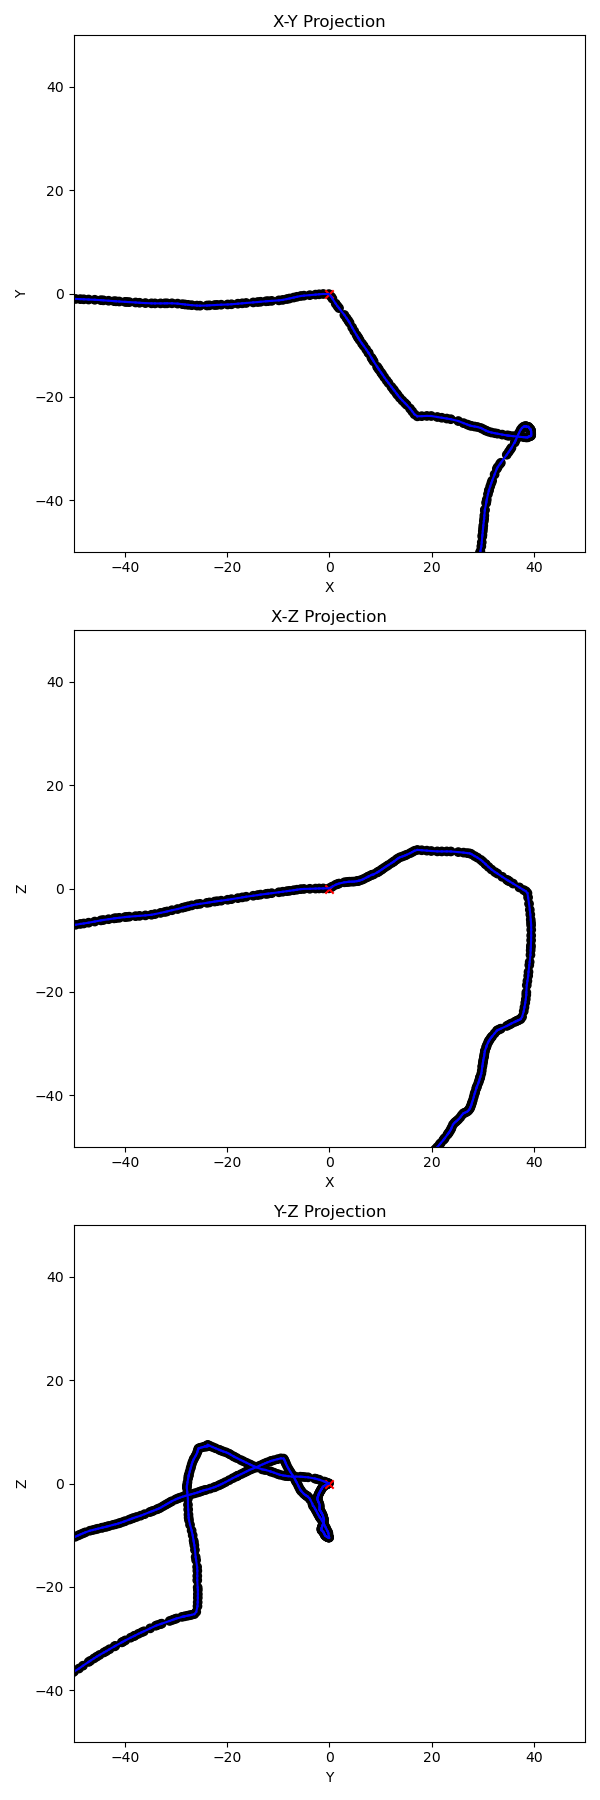

In [213]:
%matplotlib widget

event_num = 25

data = hits[hits.event_id == event_num]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# In the case of nexus, set the vertex to origin
if ("nexus" in infile):
    vertex = pd.DataFrame({'event_id': [event_num], 'x': [0], 'y': [0], 'z': [0], 'energy': [0]})
    data = pd.concat([data, vertex], ignore_index=True)

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Print energy sum
print("Energy Sum: ", data.energy.sum())

display(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Tunable parameters
init_dist_thresh = 15 # max distance for initial connections [mm]
incr_dist_thresh = [2,4,6,8,10,12,14,16,18,20] # Second stage, look for closest nodes, then slowly increase threshold [mm]
dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]

connections = []

# -----------------------------------
# Find the node that is closest to the vertex
# Calculate the Euclidean distance from the origin for each row
data['distance'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
vertex_index = data['distance'].idxmin()
# data = data.drop(columns=['distance'])
print("Vertex Index is:" , vertex_index)

# Make a connection to the two closest nodes
closest_idx = np.argsort(dist_matrix[vertex_index])[1:3]
UpdateConnections(vertex_index, closest_idx[0], connected_nodes, connections, connection_count)
UpdateConnections(vertex_index, closest_idx[1], connected_nodes, connections, connection_count)

# ------------------------------------
# Find closest nodes and create connections

for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    ax.scatter(0, 0, c="r", marker='x')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

{'id': 0, 'start': 17, 'end': 24, 'nodes': [17, 18, 24], 'length': 0.963, 'energy': 0.029325000941753387, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 2, 'start': 27, 'end': 56, 'nodes': [27, 37, 46, 51, 49, 44, 31, 22, 33, 43, 34, 23, 29, 20, 19, 15, 9, 10, 13, 12, 8, 6, 4, 2, 0, 1, 3, 5, 7, 11, 14, 16, 21, 50, 52, 47, 42, 40, 32, 36, 30, 25, 26, 28, 35, 38, 39, 41, 45, 48, 53, 54, 58, 62, 63, 61, 60, 59, 57, 55, 56], 'length': 43.897, 'energy': 0.11079999975845567, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}
{'id': 4, 'start': 1128, 'end': 1137, 'nodes': [1128, 1129, 1132, 1136, 1141, 1140, 1137], 'length': 4.072, 'energy': 0.04362500098068267, 'label': 'track', 'c': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)}
{'id': 6, 'start': 3389, 'end': 4834, 'nodes': [3389, 3388, 3398, 3406, 3411, 3414, 3417, 3408, 3412, 3409, 3404, 3418, 3420, 3425, 3432, 3434, 3442, 3448, 3452, 3460, 3

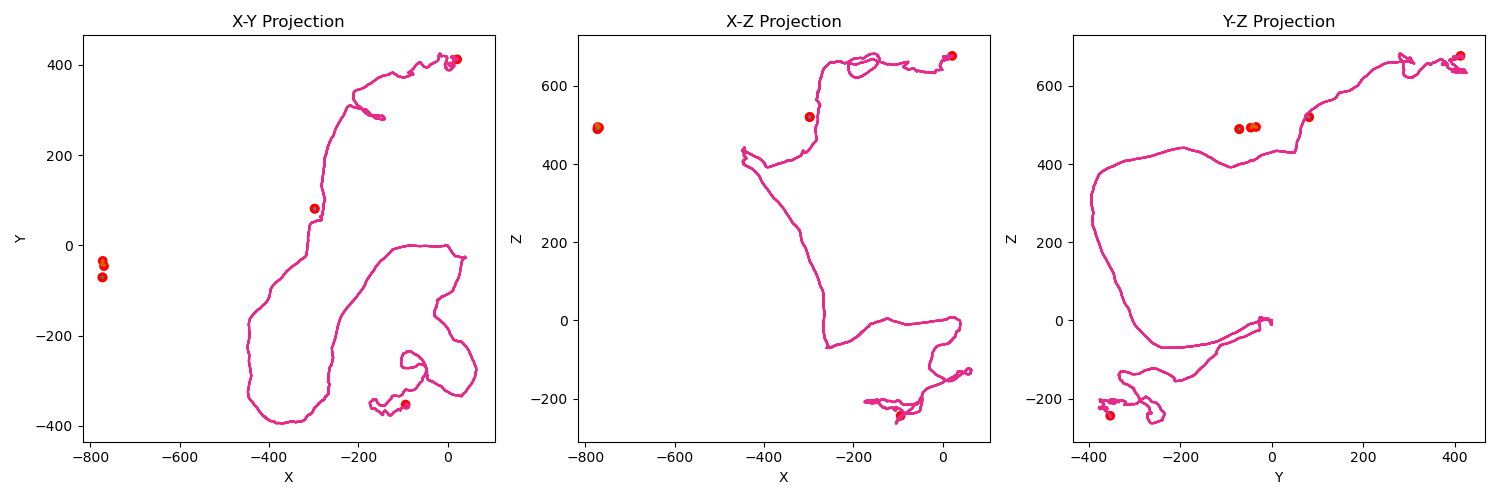

In [214]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [215]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)
# dist_threshold = 10

0.698


In [216]:
# Now look to merge tracks that are close by and identify deltas

# search connections made and make sure to get the merged id
def GetDaughterConnectionID(id_, dict_):
    for ids in dict_:
        if (ids == id_):
            return GetDaughterConnectionID(dict_[id_], dict_)
        
    print("Daughter ID is: ",id_)
    return id_

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)

# ------------------------------------------------------
# Here we break the track containing the vertex ID in two 
for t in Tracks:

    # Found the track with the vertex
    if (vertex_index in t["nodes"]):
        # Get the length either side of track
        trk1_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][0])[0:]
        trk2_path = GetNodePath(connected_nodes, vertex_index, connected_nodes[vertex_index][1])[0:]
        print("vertex:",vertex_index)
        print("Path1:",trk1_path)
        print("Path2:",trk2_path)
        CreateVertexandSplit(vertex_index, t["id"], trk1_path, trk2_path, Tracks, data)
        break

print("Printing Tracks")
for t in Tracks:
    print(t)

# ------------------------------------------------------



vertex: 4483
Path1: [4483, 4488, 4491, 4496, 4505, 4511, 4521, 4528, 4535, 4540, 4549, 4555, 4562, 4564, 4567, 4571, 4578, 4581, 4586, 4590, 4593, 4602, 4606, 4609, 4623, 4626, 4630, 4636, 4640, 4651, 4661, 4668, 4681, 4687, 4694, 4700, 4704, 4717, 4734, 4752, 4756, 4765, 4771, 4777, 4785, 4794, 4803, 4818, 4830, 4841, 4849, 4857, 4870, 4879, 4885, 4890, 4895, 4903, 4910, 4920, 4926, 4937, 4939, 4946, 4956, 4963, 4968, 4979, 4987, 4989, 4992, 4999, 5010, 5018, 5024, 5031, 5032, 5036, 5039, 5041, 5044, 5048, 5050, 5052, 5051, 5049, 5047, 5046, 5043, 5042, 5038, 5037, 5035, 5034, 5030, 5028, 5026, 5025, 5023, 5022, 5020, 5019, 5015, 5013, 5009, 5008, 5005, 5001, 5003, 4997, 4994, 4991, 4986, 4976, 4973, 4969, 4967, 4962, 4958, 4954, 4951, 4949, 4948, 4944, 4942, 4941, 4940, 4935, 4934, 4933, 4932, 4931, 4930, 4929, 4927, 4925, 4923, 4922, 4921, 4919, 4918, 4917, 4915, 4913, 4912, 4909, 4907, 4906, 4904, 4902, 4900, 4898, 4897, 4896, 4893, 4892, 4891, 4889, 4888, 4886, 4882, 4881, 4878, 4

0
25.533215524390798
25.6041855768617
25.533215524390798 25.6041855768617 2.792
Failed distance requirements
2
36.88078758523109
25.533215524390798
36.88078758523109 25.533215524390798 2.792
Failed distance requirements
4
19.894481371956182
19.11939860793393
19.894481371956182 19.11939860793393 2.792
Failed distance requirements
5
1.111235183612451
262.5432201903772
603.9805195220679 901.3247919217719 2.792
Failed distance requirements
6
0.7401068617437745
485.26179203231874
603.9805195220679 485.26179203231874 2.792
Failed distance requirements
7
Skipping Vertex...
{'id': 0, 'start': 17, 'end': 24, 'nodes': [17, 18, 24], 'length': 0.963, 'energy': 0.029325000941753387, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 2, 'start': 27, 'end': 56, 'nodes': [27, 37, 46, 51, 49, 44, 31, 22, 33, 43, 34, 23, 29, 20, 19, 15, 9, 10, 13, 12, 8, 6, 4, 2, 0, 1, 3, 5, 7, 11, 14, 16, 21, 50, 52, 47, 42, 40, 32, 36, 30, 25, 26, 28, 35, 38, 39, 41, 45, 48, 5

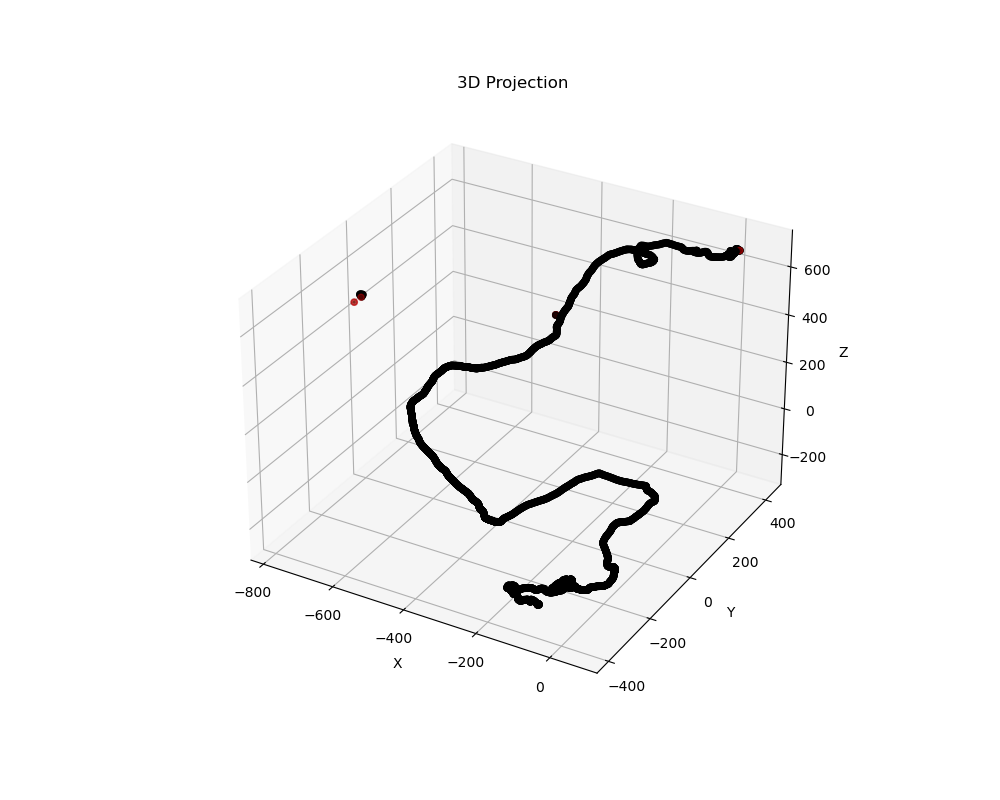

In [217]:
UpdatedTracks = copy.deepcopy(Tracks)

for idx, Track in enumerate(Tracks):
    curr_track = Track["id"]
    print(curr_track)
    curr_label = Track["label"]

    if (curr_label== "vertex"):
        print("Skipping Vertex...")
        continue
    
    start_node = Track["start"]
    end_node   = Track["end"]

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    print(dist_matrix[start_node][dist_ind_start[0]])
    print(dist_matrix[end_node][dist_ind_end[0]])

    # if we have a primary track, then filter the vertex node and the other primary track nodes
    dist_ind_start, dist_ind_end = FilterNodes(dist_ind_start, dist_ind_end, curr_label, UpdatedTracks)

    # After filtering, if no candidate nodes left, then continue
    if (len(dist_ind_start) == 0):
        continue

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        print(dist_start, dist_end, dist_threshold)
        print("Failed distance requirements")
        continue

    # Initialize
    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Get the track labels of the connecting track
    start_con_track_label = GetTrackDictwithNode(dist_ind_start[0], Tracks)["label"]
    end_con_track_label   = GetTrackDictwithNode(dist_ind_end[0], Tracks)["label"]

    # Choose the smallest index
    if ( (dist_start < dist_end or dist_ind_end[0] == vertex_index)):
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Get the track ID where the connecting node is located
    con_track      = GetTrackwithNode(closest_idx, Tracks)
    con_track_dict = GetTrackDictwithNode(closest_idx, Tracks)
    print("Connecting Track ID is:",con_track_dict["id"])

    if (con_track_dict == -1):
        print("Connecting track could not be found...")
        continue

    # The current node should not have more than 2 connections as its an end
    # The connecting node should not have more than 3 connections
    if (connection_count[closest_idx] >= 3 or connection_count[end_conn_node] >= 2):
        print("node already has three connecitons,skipping...")
        continue

    # if node-node then merge nodes and update track in Tracks
    # if (closest_idx == con_track_dict["start"] or closest_idx == con_track_dict["end"]):
        
    #     Track = UpdateTrackEnd(con_point, curr_track, closest_idx, UpdatedTracks)
    #     newpath = join_tracks(Track["nodes"],con_track_dict["nodes"])
    #     UpdateAndMergeTrack(curr_track, con_track, newpath, UpdatedTracks, data)
    #     UpdateConnections(end_conn_node, closest_idx, connected_nodes, connections, connection_count)
    #     print("node-node connection",curr_track,con_track  )
    #     continue

    # Check if the proposed connection will form a cycle
    cycle  = Testcycle(end_conn_node, closest_idx ,connected_nodes, connections, connection_count)
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        print("Connecting: ",end_conn_node, closest_idx)
        UpdateConnections(end_conn_node,closest_idx, connected_nodes, connections, connection_count)
    else:
        continue


    Track = UpdateTrackEnd(con_point, curr_track, closest_idx, UpdatedTracks)

    # Combine the track labels
    AddConnectedTracksnoDelta(curr_track, con_track, UpdatedTracks)


FixTrackEnergies(UpdatedTracks,vertex_index, data)


e_sum = 0
track_id_list = []
for t in UpdatedTracks:
    print(t)
    if t["id"] not in track_id_list:
        track_id_list.append(t["id"])

        
    e_sum+=t["energy"]

print("Tot Energy: ",e_sum)
print("Total Tracks:", len(UpdatedTracks))
print("Total Unique:", len(track_id_list))

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

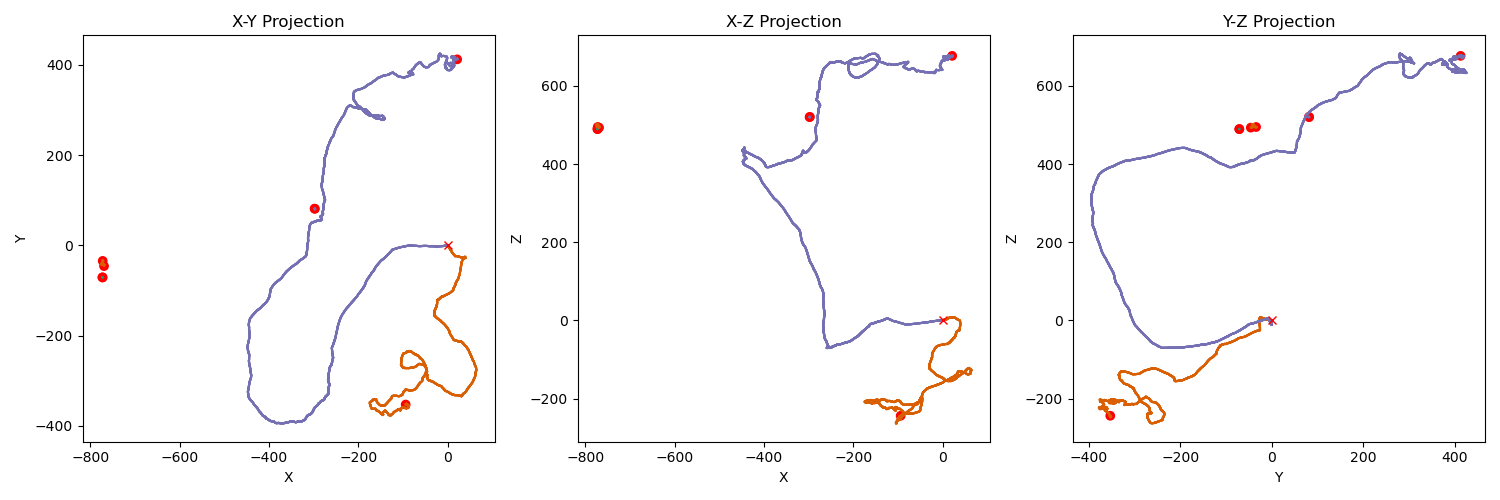

In [218]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', UpdatedTracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', UpdatedTracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', UpdatedTracks)

plt.tight_layout()
plt.show()

In [219]:
# Reconstruction level quantities

# Add gamma energy to the lowest energy track

track1_energy = 0
track2_energy = 0

for t in UpdatedTracks:

    if (t["label"] == "Track1"):
        track1_energy = track1_energy + t["energy"]

    if (t["label"] == "Track2"):
        track2_energy = track2_energy + t["energy"]

# ID the track with the lowest label
highest_track = "Track2"
if (track1_energy > track2_energy):
    highest_track = "Track1"

e_gammas = 0
for t in UpdatedTracks:

    if (t["label"] != "Track1" and t["label"] != "Track2"):
        print(t["label"])
        e_gammas = e_gammas + t["energy"]

print("Gamma Energy:",e_gammas)

if (highest_track == "Track1"):
    track1_energy = track1_energy + e_gammas
else:
    track2_energy = track2_energy + e_gammas

print("Track 1 Energy:", track1_energy)
print("Track 2 Energy:", track2_energy)
print("Tot Energy:", track1_energy + track2_energy)
Reco_T1 = ReturnLargest(track1_energy,track2_energy)


part = parts[parts.event_id == event_num]
part = part[part.primary == 1]
display(part)

gen_kin_energy = max(part.kin_energy.values) # generator T1

track
track
track
vertex
Gamma Energy: 0.18375000168089173
Track 1 Energy: 0.7930750034629455
Track 2 Energy: 1.6660250080058177
Tot Energy: 2.459100011468763


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,25,2,e-,1,0,0.0,0.0,0.0,0.0,21.138142,...,-2.107840,-0.174902,-0.016900,-0.0,0.0,-0.0,1.665003,2623.932617,none,eIoni
441,25,1,e-,1,0,0.0,0.0,0.0,0.0,-92.304985,...,0.599872,-0.968172,0.376841,-0.0,-0.0,-0.0,0.792969,1288.241333,none,eIoni


In [220]:
# Calculate the angle between the electrons

### ------------- ------------- ------------- -------------
# Filter particles with particle_id 1 and 2
particle_1 = part[part.particle_id == 1].copy()
particle_2 = part[part.particle_id == 2].copy()

# Merge the DataFrames on 'event' to pair particles from the same event
merged_particles = pd.merge(particle_1, particle_2, on="event_id", suffixes=('_1', '_2'))

# Apply the function to each row in the merged DataFrame
merged_particles['angle'] = merged_particles.apply(calculate_angle_parts, axis=1)
print("True Angle:", merged_particles['angle'].iloc[0])
# ------------- ------------- ------------- -------------

data['Track1'] = 0
data['Track2'] = 0

track1_indices = []
track2_indices = []

for t in UpdatedTracks:

    if t["label"] == "Track1":
        track1_indices = track1_indices + t["nodes"]

    if t["label"] == "Track2":
        track2_indices = track2_indices + t["nodes"]

data.loc[track1_indices, 'Track1'] = 1
data.loc[track2_indices, 'Track2'] = 1

display(data[data.distance < 5])

print(track1_indices)


True Angle: -0.43407807044677416


,x,y,z,energy,distance,Track1,Track2
4395,-4.968315,-0.411563,-0.080495,0.001100,4.985982,0,1
4420,-3.816283,-0.315811,-0.049950,0.000125,3.829654,0,1
4437,-2.694404,-0.209671,-0.011462,0.000025,2.702574,0,1
4449,-2.002887,-0.148999,0.014794,0.000700,2.008476,0,1
4470,-1.194596,-0.087186,0.024397,0.000275,1.198022,0,1
4483,-0.083702,-0.111385,0.037507,0.001600,0.144289,1,1
4488,0.389104,-0.640086,0.248903,0.000275,0.789344,1,0
4491,0.608723,-0.993603,0.390142,0.000025,1.228821,1,0
4496,1.245754,-1.959163,0.733402,0.000400,2.434769,1,0
4505,1.601213,-2.455889,0.864067,0.000375,3.056450,1,0


[4483, 4488, 4491, 4496, 4505, 4511, 4521, 4528, 4535, 4540, 4549, 4555, 4562, 4564, 4567, 4571, 4578, 4581, 4586, 4590, 4593, 4602, 4606, 4609, 4623, 4626, 4630, 4636, 4640, 4651, 4661, 4668, 4681, 4687, 4694, 4700, 4704, 4717, 4734, 4752, 4756, 4765, 4771, 4777, 4785, 4794, 4803, 4818, 4830, 4841, 4849, 4857, 4870, 4879, 4885, 4890, 4895, 4903, 4910, 4920, 4926, 4937, 4939, 4946, 4956, 4963, 4968, 4979, 4987, 4989, 4992, 4999, 5010, 5018, 5024, 5031, 5032, 5036, 5039, 5041, 5044, 5048, 5050, 5052, 5051, 5049, 5047, 5046, 5043, 5042, 5038, 5037, 5035, 5034, 5030, 5028, 5026, 5025, 5023, 5022, 5020, 5019, 5015, 5013, 5009, 5008, 5005, 5001, 5003, 4997, 4994, 4991, 4986, 4976, 4973, 4969, 4967, 4962, 4958, 4954, 4951, 4949, 4948, 4944, 4942, 4941, 4940, 4935, 4934, 4933, 4932, 4931, 4930, 4929, 4927, 4925, 4923, 4922, 4921, 4919, 4918, 4917, 4915, 4913, 4912, 4909, 4907, 4906, 4904, 4902, 4900, 4898, 4897, 4896, 4893, 4892, 4891, 4889, 4888, 4886, 4882, 4881, 4878, 4876, 4873, 4869, 486

In [221]:
# Given vertex position
vertex = data[ (data.Track1 == 1) & (data.Track2 == 1)]
vertex = np.array([vertex.iloc[0].x,vertex.iloc[0].y,vertex.iloc[0].z])
vertex = np.array([0,0,0])

# Track1 = data[ (data.Track1 == 1) & (data.Track2 != 1)]
Track1 = data.iloc[trk1_path]
# Track1 = Track1.reindex(track1_indices)
Track1 = Track1.iloc[1:] # remove vertex index

# Track2 = data[ (data.Track2 == 1) & (data.Track1 != 1)]
Track2 = data.iloc[trk2_path]
# Track2 = Track2.reindex(track2_indices)
Track2 = Track2.iloc[1:] # remove vertex index

display(Track1)
display(Track2)

# cos_theta, direction_vector1, direction_vector2 = CalcTrackAngle(Track1.iloc[0:1], Track2.iloc[0:1], vertex)
cos_theta, direction_vector1, direction_vector2 = CalcTrackAngle(Track1, Track2, vertex)

print(cos_theta)

,x,y,z,energy,distance,Track1,Track2
4488,0.389104,-0.640086,0.248903,0.000275,0.789344,1,0
4491,0.608723,-0.993603,0.390142,0.000025,1.228821,1,0
4496,1.245754,-1.959163,0.733402,0.000400,2.434769,1,0
4505,1.601213,-2.455889,0.864067,0.000375,3.056450,1,0
4511,1.895850,-2.820915,0.962791,0.001550,3.532531,1,0
...,...,...,...,...,...,...,...
3411,-92.526268,-352.436646,-244.531433,0.000075,438.826080,1,0
3406,-92.656784,-352.532990,-244.301498,0.000075,438.802917,1,0
3398,-93.046654,-352.217896,-244.352905,0.005175,438.660980,1,0
3388,-93.826782,-352.406525,-244.231400,0.015725,438.910950,1,0


,x,y,z,energy,distance,Track1,Track2
4470,-1.194596,-0.087186,0.024397,0.000275,1.198022,0,1
4449,-2.002887,-0.148999,0.014794,0.000700,2.008476,0,1
4437,-2.694404,-0.209671,-0.011462,0.000025,2.702574,0,1
4420,-3.816283,-0.315811,-0.049950,0.000125,3.829654,0,1
4395,-4.968315,-0.411563,-0.080495,0.001100,4.985982,0,1
...,...,...,...,...,...,...,...
4844,22.176952,413.656281,676.713257,0.001800,793.438232,0,1
4837,21.681530,413.114227,677.010925,0.005900,793.395996,0,1
4833,21.186945,413.006683,676.892273,0.009975,793.225403,0,1
4831,21.123808,413.625671,677.102356,0.015525,793.725403,0,1


-0.4261007184829875


(-2.0, 2.0)

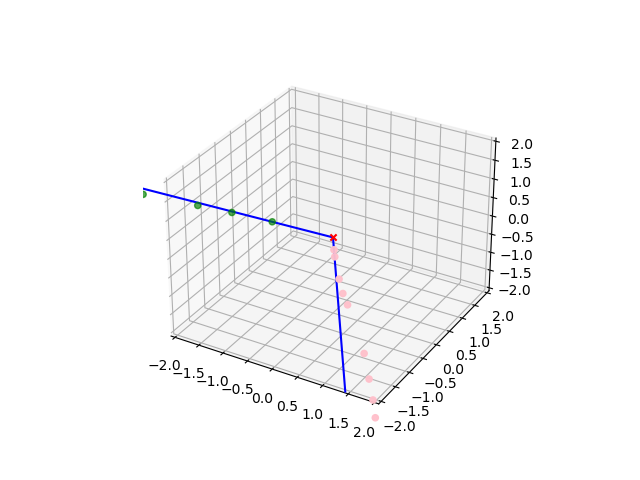

In [222]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
# ax.scatter(data.x, data.y, data.z, color='blue')
ax.scatter(vertex[0], vertex[1], vertex[2], color='red', marker="x")
ax.scatter(Track1.x, Track1.y, Track1.z, color='pink')
ax.scatter(Track2.x, Track2.y, Track2.z, color='green')

# Plot the direction vector
vector_line1 = np.array([vertex, vertex + 10*direction_vector1])  # Extend the vector for visualization
vector_line2 = np.array([vertex, vertex + 10*direction_vector2])  # Extend the vector for visualization

ax.plot(vector_line1[:, 0], vector_line1[:, 1], vector_line1[:, 2], color='blue')
ax.plot(vector_line2[:, 0], vector_line2[:, 1], vector_line2[:, 2], color='blue')

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)